# Transfer Learning With Tensorflow - Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading And Becoming One With The Data:

In [1]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in \'{dirpath}\'.')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating Data Loaders (Preparing The Data):

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1 / 255.)
test_datagen = ImageDataGenerator(rescale = 1 / 255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting Up Callbacks (Things To Run Whilst Our Model Trains):

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating Models Using TensorFlow Hub:

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model links:

https://www.kaggle.com/models/google/resnet-v2/tensorFlow2/50-feature-vector

https://www.kaggle.com/models/google/efficientnet-v2/tensorFlow2/imagenet1k-b0-feature-vector

In [5]:
# Let's compare the following two models
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2'

efficientnet_url = 'https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2'

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes = 10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer, should be equal to the number of target classes, default 10.
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
trainable = False, # Freeze the already learned patterns
name = 'feature_extraction_layer',
input_shape = IMAGE_SHAPE + (3,))
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
    ])

    return model

In [6]:
#New Version Written By ChatGPT:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)

def create_model(model_url, num_classes=10):
    """
    Creates a model using TensorFlow Hub feature extractor (Functional API).
    """
    # Input layer
    inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,), name='input_layer')

    # Wrap hub.KerasLayer in a Lambda to avoid symbolic conversion issues
    feature_extractor_layer = hub.KerasLayer(model_url, trainable=False)

    # Ensure the call happens inside Lambda
    x = layers.Lambda(lambda img: feature_extractor_layer(img))(inputs)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Build model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='hub_based_model')
    return model

In [ ]:
#Third version written by ChatGPT to avoid Lambda loading

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)

class HubFeatureExtractor(layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_layer.handle,
            "trainable": self.hub_layer.trainable,
        })
        return config

def create_model(model_url, num_classes=10):
    inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,), name="input_layer")
    x = HubFeatureExtractor(model_url, trainable=False, name="feature_extraction_layer")(inputs)
    outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="hub_based_model")


In [ ]:
#Fourth version that stores url in class normally, without handles

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)

class HubFeatureExtractor(layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url  # store manually
        self.trainable_flag = trainable
        self.hub_layer = hub.KerasLayer(self.hub_url, trainable=self.trainable_flag)

    def call(self, inputs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_url,
            "trainable": self.trainable_flag,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def create_model(model_url, num_classes=10):
    inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,), name="input_layer")
    x = HubFeatureExtractor(model_url, trainable=False, name="feature_extraction_layer")(inputs)
    outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="hub_based_model")


In [22]:
#Fifth version that makes the custom layer registerable

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.saving import register_keras_serializable  # <-- important

IMAGE_SHAPE = (224, 224)

@register_keras_serializable(package="Custom", name="HubFeatureExtractor")
class HubFeatureExtractor(layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url
        self.trainable_flag = trainable
        self.hub_layer = hub.KerasLayer(self.hub_url, trainable=self.trainable_flag)

    def call(self, inputs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_url,
            "trainable": self.trainable_flag,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def create_model(model_url, num_classes=10):
    inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,), name="input_layer")
    x = HubFeatureExtractor(model_url, trainable=False, name="feature_extraction_layer")(inputs)
    outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="hub_based_model")


### Creating And Testing ResNet TensorFlow Hub Feature Extraction Model:

In [23]:
# Create Resnet model
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

In [24]:
resnet_model.summary()

Model: "hub_based_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extraction_layer        │ (None, 2048)           │             0 │
│ (HubFeatureExtractor)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile our resnet model
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [26]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
epochs = 5,
steps_per_epoch = len(train_data_10_percent),
validation_data = test_data,
validation_steps = len(test_data),
callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250828-144320
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 332s 14s/step - accuracy: 0.1622 - loss: 2.5774 - val_accuracy: 0.5860 - val_loss: 1.3242
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 233s 10s/step - accuracy: 0.6942 - loss: 1.0703 - val_accuracy: 0.6948 - val_loss: 0.9142
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - accuracy: 0.7877 - loss: 0.7155 - val_accuracy: 0.7528 - val_loss: 0.7684
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 219s 9s/step - accuracy: 0.8675 - loss: 0.5107 - val_accuracy: 0.7784 - val_loss: 0.7127
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 231s 10s/step - accuracy: 0.9049 - loss: 0.3921 - val_accuracy: 0.7744 - val_loss: 0.6891


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [27]:
#Save resnet model
resnet_model.save('resnet_model.keras')

In [29]:
#Load resnet model
resnet_model = tf.keras.models.load_model('resnet_model.keras')

In [30]:
# Let's create a function to plot our loss curves...
# Tidbit: You could put a function like this called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object.
    
    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

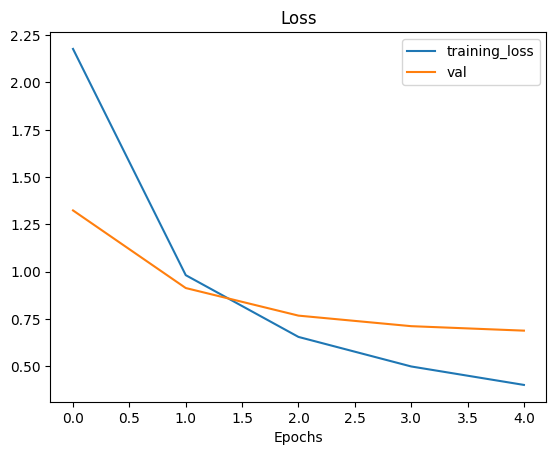

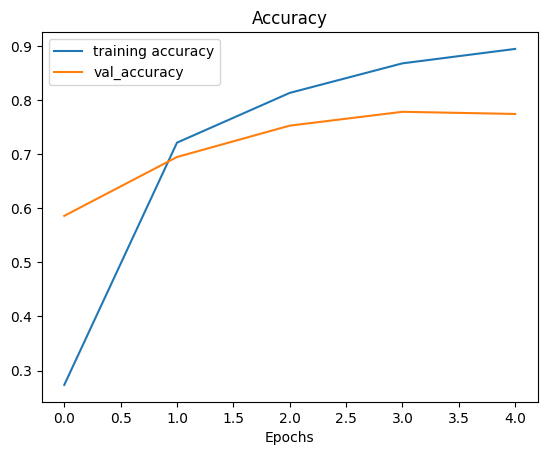

In [31]:
plot_loss_curves(resnet_history) #There may be slight overfitting, but this proves that this model is way better than ANY of the multiclass CNNs hand crafted in the previous lecture

### Creating And Testing EfficientNetB0 TensorFlow Hub Feature Extraction Model:

In [32]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/
efficientnet_model = create_model(model_url = efficientnet_url,
num_classes = train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
epochs = 5,
steps_per_epoch = len(train_data_10_percent),
validation_data = test_data,
validation_steps = len(test_data),
callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20250828-150659
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.2427 - loss: 2.1757 - val_accuracy: 0.6092 - val_loss: 1.5293
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6695 - loss: 1.3912 - val_accuracy: 0.7116 - val_loss: 1.1332
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7634 - loss: 1.0317 - val_accuracy: 0.7360 - val_loss: 0.9610
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7920 - loss: 0.8538 - val_accuracy: 0.7512 - val_loss: 0.8637
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.8147 - loss: 0.7378 - val_accuracy: 0.7648 - val_loss: 0.8027


In [33]:
#Save efficientnet model
efficientnet_model.save('efficientnet_model.keras')

In [34]:
#Load efficientnet model
efficientnet_model = tf.keras.models.load_model('efficientnet_model.keras')

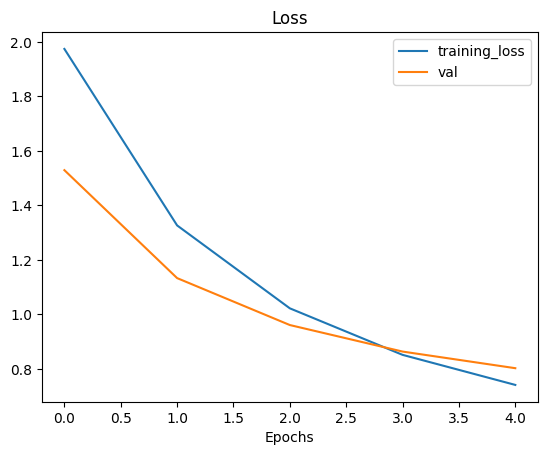

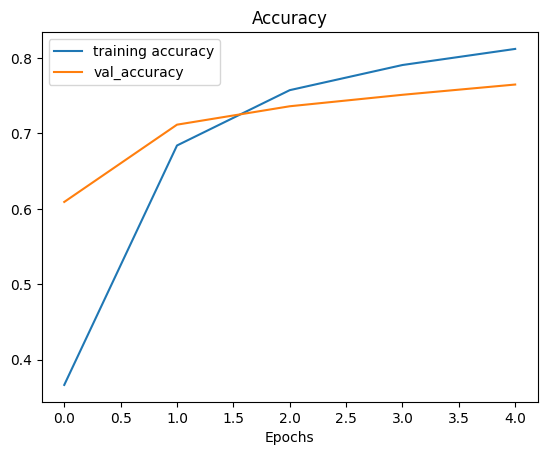

In [35]:
plot_loss_curves(efficientnet_history)

In [36]:
efficientnet_model.summary()

Model: "hub_based_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extraction_layer        │ (None, 1280)           │             0 │
│ (HubFeatureExtractor)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,432 (150.13 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,622 (100.09 KB)

In [37]:
resnet_model.summary()

Model: "hub_based_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extraction_layer        │ (None, 2048)           │             0 │
│ (HubFeatureExtractor)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,472 (240.13 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,982 (160.09 KB)

In [38]:
# How many layers does our efficientnetb0 feature extractor have?
efficientnet_model.layers

[<InputLayer name=input_layer, built=True>,
 <HubFeatureExtractor name=feature_extraction_layer, built=True>,
 <Dense name=output_layer, built=True>]

## Different Types Of Transfer Learning:

* **"As is" transfer learning** - Using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - Use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - Use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing Our Models' Results Using TensorBoard:

🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see), do not upload them to TensorBoard.dev.

In [41]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot

2025-08-28 15:21:53.919485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:21:56.820040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


⚠️ Come back after you finish this course to find a replacement to TensorBoard.dev!

In [46]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2025-08-28 15:32:33.850589: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:32:41.067129: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [47]:
# Delete an experiment
!tensorboard dev delete --experiment_id (insert experiment ID here)

2025-08-28 15:33:47.791749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:33:49.600494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [48]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

2025-08-28 15:34:50.911228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:34:59.913777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.
